## You have to start your own instance of ipcluster if you're using the API.
Actually _you_ don't have to do it bcz I did it already, but if you want to know how it's like this:

    ipcluster start -n 12 --daemonize

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]

import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import numpy as np
import ipyrad as ip
import collections
import allel
import vcfnp
import sys                 ## for sys.exit()
import os

In [3]:
## You need to update this directory to reflect the reality of your path
WORK_DIR = "/Users/iovercast/Desktop/lab-notebooks/code-school/tmp/"
os.chdir(WORK_DIR)

## Load in the current assembly
Your work directory has a full completed assembly from a small simulated dataset. Lets load
in this assembly and poke around a little. 

In [4]:
## Load the current assembly. If you set your WORK_DIR correctly this should work fine.
#data1 = ip.load_json(WORK_DIR + "ipyrad-test/ipyrad-test.json")
assembly_name = "my_assembly"
data1 = ip.Assembly(assembly_name)


  New Assembly: my_assembly


## Print the default params for the current assembly.

In [5]:
data1.get_params()

  0   assembly_name               my_assembly                                  
  1   project_dir                 ./                                           
  2   raw_fastq_path                                                           
  3   barcodes_path                                                            
  4   sorted_fastq_path                                                        
  5   assembly_method             denovo                                       
  6   reference_sequence                                                       
  7   datatype                    rad                                          
  8   restriction_overhang        ('TGCAG', '')                                
  9   max_low_qual_bases          5                                            
  10  phred_Qscore_offset         33                                           
  11  mindepth_statistical        6                                            
  12  mindepth_majrule            6     

You can see that the default parameters don't include paths to raw data or barcodes files, so we'll
add these now. Also note the value of `min_samples_locus`, as we'll be modifying this later.

In [6]:
data1.set_params("raw_fastq_path", "/Volumes/WorkDrive/ipyrad/ipyrad/tests/ipsimdata/rad_example_R1_.fastq.gz")
data1.set_params("barcodes_path", "/Volumes/WorkDrive/ipyrad/ipyrad/tests/ipsimdata/rad_example_barcodes.txt")

In [7]:
## We can write the params to a file if we want to inspect or modify them at the command line
## The default simply writes `params-<assembly_name>.txt` to the project directory
!ls
data1.write_params()
!ls

QC_and_PCA.ipynb       my_assembly_consens    nomissing.json
ipyrad_log.txt         my_assembly_edits      params-my_assembly.txt
my_assembly.json       my_assembly_fastqs
my_assembly_clust_0.85 my_assembly_outfiles


IPyradError: 
    Error: Params file already exists: params-my_assembly.txt
    Use force argument to overwrite.
    

## Now run the full assembly

In [11]:
data1.run(steps=1234567)


  Assembly: my_assembly

  [####################] 100%  sorting reads         | 0:00:09 | s1 | 
  [####################] 100%  writing/compressing   | 0:00:00 | s1 | 
  [####################] 100%  processing reads      | 0:00:07 | s2 | 
  [####################] 100%  dereplicating         | 0:00:00 | s3 | 
  [####################] 100%  clustering            | 0:00:02 | s3 | 
  [####################] 100%  building clusters     | 0:00:00 | s3 | 
  [####################] 100%  chunking              | 0:00:00 | s3 | 
  [####################] 100%  aligning              | 0:00:19 | s3 | 
  [####################] 100%  concatenating         | 0:00:00 | s3 | 
  [####################] 100%  inferring [H, E]      | 0:00:03 | s4 | 
  [####################] 100%  calculating depths    | 0:00:00 | s5 | 
  [####################] 100%  chunking clusters     | 0:00:00 | s5 | 
  [####################] 100%  consens calling       | 0:00:32 | s5 | 
  [####################] 100%  concat/shuffle input

## Examine the outfiles

In [8]:
outfiles = WORK_DIR + "my_assembly_outfiles/"
os.listdir(outfiles)

['my_assembly.hdf5',
 'my_assembly.loci',
 'my_assembly.phy',
 'my_assembly.snps.map',
 'my_assembly.snps.phy',
 'my_assembly.vcf',
 'my_assembly_stats.txt']

In [12]:
## Get some info about the state of each sample and the results from all the steps.
data1.stats

,state,reads_raw,reads_passed_filter,clusters_total,clusters_hidepth,hetero_est,error_est,reads_consens
1A_0,6,19862,19862,1000,1000,0.001824,0.000759,1000
1B_0,6,20043,20043,1000,1000,0.001908,0.000752,1000
1C_0,6,20136,20136,1000,1000,0.002084,0.000745,1000
1D_0,6,19966,19966,1000,1000,0.001803,0.000761,1000
2E_0,6,20017,20017,1000,1000,0.001830,0.000766,1000
2F_0,6,19933,19933,1000,1000,0.001996,0.000755,1000
2G_0,6,20030,20030,1000,1000,0.001940,0.000763,1000
2H_0,6,20199,20199,1000,1000,0.001747,0.000756,1000
3I_0,6,19885,19885,1000,1000,0.001807,0.000758,1000
3J_0,6,19822,19822,1000,1000,0.001931,0.000776,1000


## Now we'll create a new branch with no missing data
Branching creates a shallow copy of an assembly at any given step. It's called a branch
because it essentially allows each branched assembly to run independently without writing over the
files of the other branch. In this case we want to re-run step 7 on the same assembled
data, but we want to modify a parameter to allow for no missing data. In order to do this we need 
to know how many samples are in the assembly, so we can ask like this:

In [13]:
print(len(data1.samples))

12


Now call the `branch` function and then set the `min_samples_locus` value to equal the total
number of samples in the assembly.

In [14]:
nomissing = data1.branch("nomissing")
nomissing.set_params("min_samples_locus", 12)
nomissing.get_params()
#nomissing.get_params("min_samples_locs")

  0   assembly_name               nomissing                                    
  1   project_dir                 ./                                           
  2   raw_fastq_path              /Volumes/WorkDrive/ipyrad/ipyrad/tests/ipsimdata/rad_example_R1_.fastq.gz
  3   barcodes_path               /Volumes/WorkDrive/ipyrad/ipyrad/tests/ipsimdata/rad_example_barcodes.txt
  4   sorted_fastq_path                                                        
  5   assembly_method             denovo                                       
  6   reference_sequence                                                       
  7   datatype                    rad                                          
  8   restriction_overhang        ('TGCAG', '')                                
  9   max_low_qual_bases          5                                            
  10  phred_Qscore_offset         33                                           
  11  mindepth_statistical        6                             

## Now run step 7 on your branched assembly


In [15]:
nomissing.run(steps=7)


  Assembly: nomissing
  [####################] 100%  filtering loci        | 0:00:00 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:00 | s7 | 
  [####################] 100%  building vcf file     | 0:00:01 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:00 | s7 | 
  [####################] 100%  building arrays       | 0:00:00 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:04 | s7 | 
  Outfiles written to: /Volumes/WorkDrive/lab-notebooks/code-school/tmp/nomissing_outfiles


## Establish paths to your vcf files and load in the vcf data
Here we'll create 2 new variables to point to our 2 vcf files. Then we'll use the external `vcfnp` library to load in the snp data.

In [21]:
missing_vcf_file = WORK_DIR + assembly_name + "_outfiles/{}.vcf".format(assembly_name)
nomissing_vcf_file = WORK_DIR + "nomissing_outfiles/nomissing.vcf"

print(missing_vcf_file)
print(nomissing_vcf_file)

for my_vcf in [missing_vcf_file, nomissing_vcf_file]:
    if not os.path.exists(my_vcf):
        print(my_vcf)
        sys.exit("Can't find vcf file!")

/Users/iovercast/Desktop/lab-notebooks/code-school/tmp/my_assembly_outfiles/my_assembly.vcf
/Users/iovercast/Desktop/lab-notebooks/code-school/tmp/nomissing_outfiles/nomissing.vcf


In [22]:
## Load in vcf call data
missing_calldata = vcfnp.calldata_2d(missing_vcf_file, verbose=False).view(np.recarray)
nomissing_calldata = vcfnp.calldata_2d(nomissing_vcf_file, verbose=False).view(np.recarray)

## Set populations and population colors
Since we will want to identify individuals in the PCA by "population" we have to establish population lists that contain the sample names of each sample per pop. We also have a dictionary that maps labels to lists, and a dictionary that assigns colors to each label.

In [23]:
pops = ["pop1", "pop2", "pop3"]
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]

## Make one big list with all the samples together _in the same order_ as the vcf file.
## Otherwise your PCA will be messed up.
sample_names = pop1 + pop2 + pop3

## YMMV here, at the end of the day you need an ordered dictionary mapping sample names to population names.
pop_dict = collections.OrderedDict([(y, "pop" + y[0]) for y in sample_names])
print(pop_dict)

## Set colors for plotting each pop. You can play with these.
pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}

OrderedDict([('1A_0', 'pop1'), ('1B_0', 'pop1'), ('1C_0', 'pop1'), ('1D_0', 'pop1'), ('2E_0', 'pop2'), ('2F_0', 'pop2'), ('2G_0', 'pop2'), ('2H_0', 'pop2'), ('3I_0', 'pop3'), ('3J_0', 'pop3'), ('3K_0', 'pop3'), ('3L_0', 'pop3')])


## Two functions for getting PCA data and plotting the 1st and 2nd PCs

In [24]:
def getPCA(call_data):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    return coords1, model1

In [25]:
def plotPCA(call_data, title):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    for pop in pops:
        flt = (np.array(pop_dict.values()) == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()

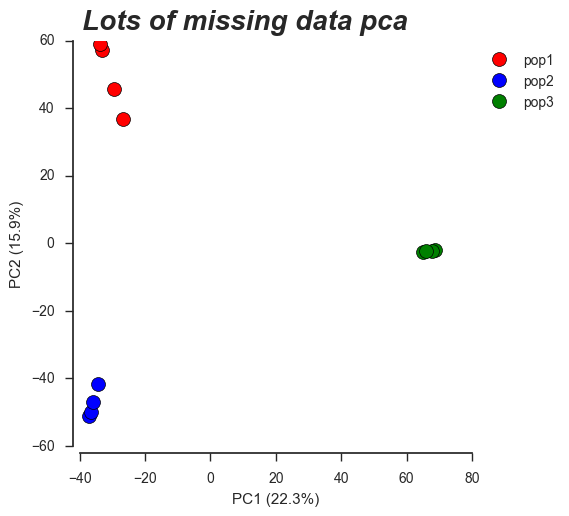

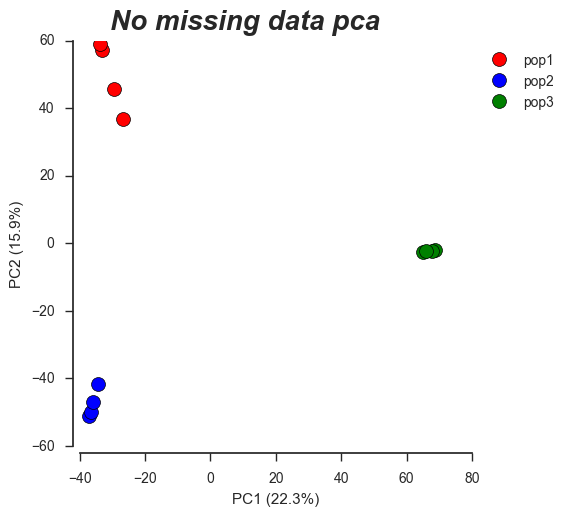

In [26]:
plotPCA(missing_calldata, "Lots of missing data")
plotPCA(nomissing_calldata, "No missing data")

## Further exploration with pairwise distance matrices
If there's time or if you have inclination to try another plotting function.

In [ ]:
def plotPairwiseDistance(call_data, title):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

def getDistances(call_data):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    return(dist)

## Ignore below here

In [11]:
watdo = ip.Assembly("watdo", profile="watdo")

  New Assembly: watdo


In [21]:
param = "min_samples_locus"
try:                                                                                                                                     
    if int(param):                                                                                                                       
        #sys.stdout.write(self.paramsdict.values()[int(param)-1])                                                                        
        print data1.paramsdict.values()[int(param)]                                                                                      
except (ValueError, TypeError, NameError, IndexError):                                                                                   
    try:                                                                                                                          
        print(data1.paramsdict[param])                                                                                                    
    except KeyError:                                                                                                                     
        print('key not recognized')  

4


In [18]:
import sys
sys.path
sys.modules.keys()
sys.modules["ipyrad.core"]

<module 'ipyrad.core' from '/usr/local/opt/miniconda/lib/python2.7/site-packages/ipyrad/core/__init__.pyc'>

In [ ]:
## 2 dif strategies for deep reloading ipyrad lib, neither work.
##import __builtin__
##from IPython.lib import deepreload
##__builtin__.reload = deepreload.reload

##reload(sys.modules['ipyrad'])

##-------------------

##%load_ext autoreload